In [32]:
import numpy as np
import pandas as pd
from pymoo.optimize import minimize

In [35]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class Brt(ElementwiseProblem):
    
    def __init__(self, M=10,N=23):
        xl = 0* np.ones(7*M*N+2*N+2)
        xu = np.ones(7*M*N+2*N+2)
        xl=np.insert(xl,-1,0)
        xl=np.insert(xl,-4,0)
        xu=np.insert(xu,-1,10)
        xu=np.insert(xu,-4,10)
        super().__init__(n_var=7*M*N+2*N+4, n_obj=2, n_constr=9, xl=xl, xu=xu, type_var=np.int32)
        self.M=M
        self.N=N
        self.L=M*N
        self.sj=2*(M*N)
        self.sjk=3*(M*N)
        self.t=3*(M*N)+N
        self.r=3*(M*N)+2*N
        self.Aj=4*(M*N)+2*N
        self.Bj=5*(M*N)+2*N
        self.Tjk=6*(M*N)+2*N
        self.T0=30
        self.c=6
        #l=X[-2]
        #h=X[-3]
        #ljk=X[-4]
        #I=X[-1]
        
    def F1(self,X):
        ls=[]
        ls2=[]
        for j in range(self.N):
            for k in range(j+1,self.N):
                y=sum([X[self.r+j]*(X[I*self.N+j]-X[I-1*self.N+j])**2/2 for I in range(1,int(X[-4]))])
                y2=sum([X[self.Tjk+I*self.N+j]*X[self.r+j]*(X[I*self.N+j]-X[I-1*self.N+j]) for I in range(1,int(X[-4]))])
                ls.append(y)
                ls2.append(y2)
                
        return sum(ls)+sum(ls2)
    def F2(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(self.N):
                x=i*self.N+j
                y=(X[x+1]-X[x])*abs(X[self.L+x]-25)
                ls.append(y)
        return sum(ls)
     
    def ff(self,i,m,j,X):
        x=X[i*self.N+j]
        y=X[m*self.N+j]
        if x>y and (x==y or i>m):
            return 1
        elif x<y and (x==y or i<m):
            return 0
        else: return 0 
        
    def g1(self,X):
        ls=[]
        for i in range(self.M):
            y=X[i*self.N]-(i)*3
            ls.append(y)
        return sum(ls)
    
    def g2(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(1,self.N):
                x=i*self.N+j
                y=-X[x]+X[x-1]+X[self.t+j]+(X[self.sj+x]+X[self.sj+x-1])*self.c+X[self.sj+x]*self.T0
                ls.append(y)
        return sum(ls)
    
    def g3(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(self.N):
                for s in range(j+1,self.N):
                    x=i*self.N+j
                    k=i*self.N+s
                    y=-X[self.sjk+x]+X[self.sj+x]*X[self.sj+k]
                    ls.append(y)
        return sum(ls)
    
    def g4(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(self.N):
                x=i*self.N+j
                ls.append(X[self.sjk+x])
        return X[-4]-sum(ls)
    
    def g5(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(self.N):
                x=i*self.N+j
                s=[]
                for m in range(self.M):
                    if m==i:
                        continue
                    k=m*self.N+j
                    s.append(X[self.sjk+k]*self.ff(i,m,j,X))
                ls.append(X[self.sjk+x]*sum(s)+1)
        return X[-1]-sum(ls)
    def g7(self,X):
        ls=[]
        for I in range(int(X[-1]),int(X[-4])):
            for j in range(1,self.N):
                for s in range(j+1,self.N):
                    x=I*self.N+j
                    k=I*self.N+s
                    ls.append(X[k]-X[x]-X[self.Tjk+x]-self.T0)
        return sum(ls)
    
    def g8(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(self.N):
                x=i*self.N+j
                s=[]
                for k in range(j-1):
                    K=i*self.N+k
                    y=sum([X[self.sj+K]*X[self.r+k]*(X[I*self.N+k]-X[I-1*self.N+k]) for I in range(1,int(X[-4]))])
                    s.append(y)
                ls.append(-X[self.Aj+x]+sum(s)*X[self.sj+x])
        return sum(ls)
    
    def g9(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(self.N):
                x=i*self.N+j
                s=[]
                for k in range(j+1,self.N):
                    K=i*self.N+k
                    y=sum([X[self.sj+K]*X[self.r+j]*(X[I*self.N+j]-X[I-1*self.N+j]) for I in range(1,int(X[-4]))])
                    s.append(y)
                ls.append(-X[self.Bj+x]+sum(s)*X[self.sj+x])
        return sum(ls)   
    
    def g10(self,X):
        ls=[]
        for i in range(self.M):
            for j in range(1,self.N):
                x=i*self.N+j
                y=-X[self.L+x]+X[self.L+x-1]+X[self.Bj+x]-X[self.Aj+x]
                ls.append(y)
                
        return sum(ls)

    def _evaluate(self, X, out, *args, **kwargs):
        # objectives
        
        f2=self.F2(X)
        f1=self.F1(X)
        out["F"] = [f1,f2]
        
        # constraints
        g1=self.g1(X)
        g2=self.g2(X)
        g3=self.g3(X)
        g4=self.g4(X)
        g5=self.g5(X)
        g7=self.g7(X)
        g8=self.g8(X)
        g9=self.g9(X)
        g10=self.g10(X)
        out["G"] =[g1,g2,g3,g4,g5,g7,g8,g9,g10]

problem = Brt()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      300 |      1 |  4.245142E+03 |  4.708436E+03 |             - |             -
     2 |      600 |      1 |  3.531842E+03 |  4.341219E+03 |             - |             -
     3 |      900 |      1 |  2.803314E+03 |  3.895514E+03 |             - |             -
     4 |     1200 |      1 |  2.295563E+03 |  3.377453E+03 |             - |             -
     5 |     1500 |      1 |  1.841606E+03 |  2.878161E+03 |             - |             -
     6 |     1800 |      1 |  1.407982E+03 |  2.436567E+03 |             - |             -
     7 |     2100 |      1 |  1.117068E+03 |  2.035934E+03 |             - |             -
     8 |     2400 |      1 |  9.641968E+02 |  1.673089E+03 |             - |             -
     9 |     2700 |      1 |  8.033507E+02 |  1.390544E+03 |             - |             -
    10 |     3000 |      1 |  6.777400E+02 |  1.156952E+03 |             - |             -

    89 |    26700 |      1 |  2.7313852618 |  2.9067212232 |             - |             -
    90 |    27000 |      1 |  2.4113696329 |  2.8364746493 |             - |             -
    91 |    27300 |      1 |  2.3920964772 |  2.7771534914 |             - |             -
    92 |    27600 |      1 |  2.3500888684 |  2.7060858829 |             - |             -
    93 |    27900 |      1 |  2.2903419665 |  2.6276097931 |             - |             -
    94 |    28200 |      1 |  2.2086432330 |  2.5294716264 |             - |             -
    95 |    28500 |      1 |  2.0405886632 |  2.3920877477 |             - |             -
    96 |    28800 |      1 |  1.9554901095 |  2.2680785676 |             - |             -
    97 |    29100 |      1 |  1.7366013930 |  2.1662286387 |             - |             -
    98 |    29400 |      1 |  1.6470211735 |  2.0563967061 |             - |             -
    99 |    29700 |      1 |  1.6470211735 |  1.9564314972 |             - |             -

   180 |    54000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0099517828 |         ideal
   181 |    54300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0364769266 |         ideal
   182 |    54600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0094871059 |         ideal
   183 |    54900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0587718207 |         ideal
   184 |    55200 |      2 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   185 |    55500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0477956083 |         ideal
   186 |    55800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0242612842 |         ideal
   187 |    56100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0509121690 |         ideal
   188 |    56400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   189 |    56700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0245930514 |         ideal
   190 |    57000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   271 |    81300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0425897574 |         ideal
   272 |    81600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0077393171 |         ideal
   273 |    81900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0973585826 |         ideal
   274 |    82200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   275 |    82500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0336588496 |         ideal
   276 |    82800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0122006283 |         ideal
   277 |    83100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0633244048 |         ideal
   278 |    83400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0183516299 |         ideal
   279 |    83700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0663685403 |         ideal
   280 |    84000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0127346183 |         ideal
   281 |    84300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0428860423 |         ideal

   362 |   108600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0157225219 |         ideal
   363 |   108900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0153482777 |         ideal
   364 |   109200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0264289883 |         ideal
   365 |   109500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0274113417 |         ideal
   366 |   109800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0419606874 |         ideal
   367 |   110100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0366975861 |         ideal
   368 |   110400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0147126398 |         ideal
   369 |   110700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0252202795 |         ideal
   370 |   111000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0369633083 |         ideal
   371 |   111300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0714560523 |         ideal
   372 |   111600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   453 |   135900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0299972823 |         ideal
   454 |   136200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0163982339 |         ideal
   455 |   136500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0611013932 |         ideal
   456 |   136800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0121951411 |         ideal
   457 |   137100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0834835302 |         ideal
   458 |   137400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0074101936 |         ideal
   459 |   137700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0310108631 |         ideal
   460 |   138000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0304931600 |         ideal
   461 |   138300 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0182887441 |         ideal
   462 |   138600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0182285481 |         ideal
   463 |   138900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0482668379 |         ideal

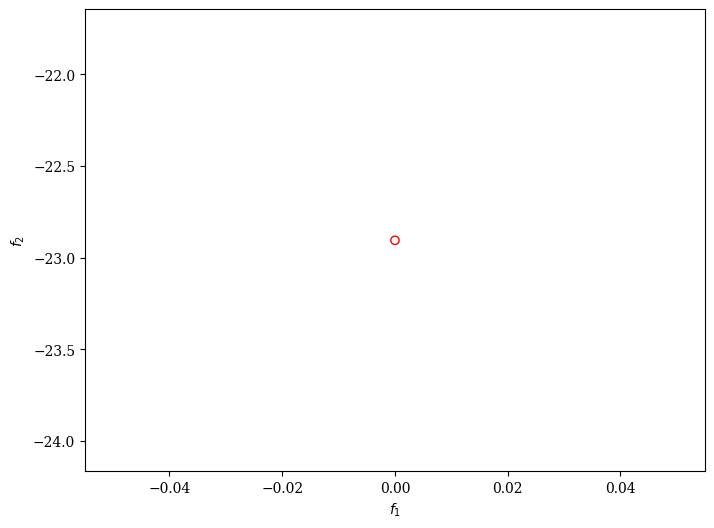

In [37]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.visualization.scatter import Scatter

algorithm = NSGA2(pop_size=300)
termination = get_termination("n_gen", 500)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()